# Weekly Project: Image Classification with Transfer Learning

In this project, you will build a complete image classification pipeline using transfer learning. You'll work with the dataset provided by your instructor.

**Learning Objectives:**
- Load and prepare image datasets for deep learning
- Use pre-trained models for transfer learning
- Implement two transfer learning strategies: fine-tuning and feature extraction
- Evaluate model performance
- Deploy models using ONNX for production (Optional)

**References:**

- [Training with PyTorch](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html)
- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

## Table of Contents

1. [Data Ingestion](#1)
2. [Data Preparation](#2)
3. [Model Building](#3)
4. [Training](#4)
   - [4.1 ConvNet as Fixed Feature Extractor](#4-1)
   - [4.2 Fine-tuning the ConvNet](#4-2)
5. [Evaluation](#5)
6. [Inference on Custom Images](#6)
7. [Deployment (ONNX)](#7)

## Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()

## Setup Device



```
`# This is formatted as code`
```

**Note: you will need a GPU; so please run this on Colab and specify a GPU runtime (e.g., T4-GPU)**

In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


<a name='1'></a>
## 1. Data Ingestion

**Task**: The dataset should be downloaded and extracted to a local directory.

**References:**

- [Dataset and DataLoader](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#dataset-and-dataloader)
- [torchvision.datasets.ImageFolder](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html)

In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'intel-image-classification' dataset.
Path to dataset files: /kaggle/input/intel-image-classification


**Task**: create a `train_dataset` and `test_dataset` (without transforms for now).

In [5]:
# YOUR CODE HERE
from torchvision import datasets
import os

# Paths to train and test folders
train_dir = os.path.join(path, "seg_train", "seg_train")
test_dir  = os.path.join(path, "seg_test", "seg_test")

# Create datasets (no transforms yet)
train_dataset = datasets.ImageFolder(root=train_dir)
test_dataset  = datasets.ImageFolder(root=test_dir)

# Quick sanity check
print("Number of training images:", len(train_dataset))
print("Number of test images:", len(test_dataset))
print("Classes:", train_dataset.classes)

Number of training images: 14034
Number of test images: 3000
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


**Quick Check**: verify the counts of both train and test sets, match what's in the original source (Kaggle).

> Add blockquote



In [6]:
# YOUR CODE HERE
# Quick check: verify dataset sizes
print("Training set size:", len(train_dataset))
print("Test set size:", len(test_dataset))


Training set size: 14034
Test set size: 3000


<a name='2'></a>
## 2. Data Preparation

Before training, we need to:
1. Define augmentation for training
2. Define normalization for both training and testing
3. Create **`DataLoader`** for efficient batch processing

**Task:** Create transformation pipelines for training and validation. Pre-trained models expect ImageNet normalization statistics.

**Reference:**

- [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)

In [7]:
# YOUR CODE HERE
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import os

# ImageNet normalization stats (required for pretrained models)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

IMG_SIZE = 224  # common size for pretrained CNNs

# 1) Transforms
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# 2) Re-create datasets WITH transforms
train_dir = os.path.join(path, "seg_train", "seg_train")
test_dir  = os.path.join(path, "seg_test", "seg_test")

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_dataset  = datasets.ImageFolder(root=test_dir,  transform=val_transforms)

# 3) DataLoaders
BATCH_SIZE = 32
NUM_WORKERS = 2  # Colab usually ok with 2

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print("Train batches:", len(train_loader))
print("Test batches:", len(test_loader))
print("Classes:", train_dataset.classes)


Train batches: 439
Test batches: 94
Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
# YOUR CODE HERE

**Quick Check**: Visualize a batch of training images

In [8]:
helper_utils.visualize_batch?

Object `helper_utils.visualize_batch` not found.


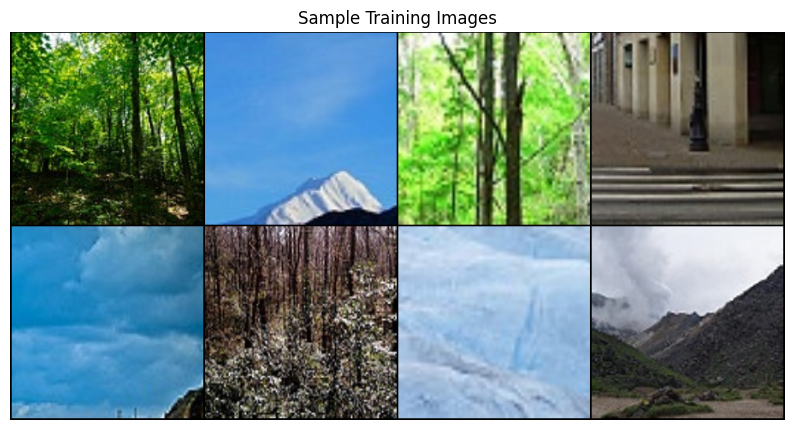

In [9]:
# YOUR CODE HERE
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Get one batch of training images
images, labels = next(iter(train_loader))

# Function to unnormalize images for visualization
def unnormalize(img):
    img = img.clone()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = img * std + mean
    return img

# Unnormalize a batch
images = torch.stack([unnormalize(img) for img in images])

# Make a grid
grid = torchvision.utils.make_grid(images[:8], nrow=4)

# Plot
plt.figure(figsize=(10,6))
plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
plt.axis("off")
plt.title("Sample Training Images")
plt.show()


<a name='3'></a>
## 3. Model Building

We'll use a pre-trained ResNet-18 model and adapt it for our 6-class classification task.

**Task:** Load a pre-trained ResNet-18 model and modify the final layer for 6 classes.

**Reference:**

- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
- [torchvision.models](https://pytorch.org/vision/stable/models.html)
- [ResNet documentation](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html)

In [10]:
# YOUR CODE HERE
import torch
import torch.nn as nn
from torchvision import models

NUM_CLASSES = 6

# 1) Load pretrained ResNet-18
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# 2) Replace final fully-connected layer
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, NUM_CLASSES)

# Move model to device
model = model.to(device)

print(model.fc)


Linear(in_features=512, out_features=6, bias=True)


<a name='4'></a>
## 4. Training

**Task:** Implement a training **function** and then train using two different transfer learning strategies.

**Reference:** [PyTorch Training Tutorial](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop)

In [11]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=5):
    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    for epoch in range(epochs):
        # -------- Train --------
        model.train()
        running_loss, running_correct, total = 0.0, 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [train]", leave=False):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            running_correct += (preds == labels).sum().item()
            total += images.size(0)

        train_loss = running_loss / total
        train_acc = running_correct / total

        # -------- Validate/Test --------
        model.eval()
        val_running_loss, val_running_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [val]", leave=False):
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item() * images.size(0)
                preds = outputs.argmax(dim=1)
                val_running_correct += (preds == labels).sum().item()
                val_total += images.size(0)

        val_loss = val_running_loss / val_total
        val_acc = val_running_correct / val_total

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"train loss: {train_loss:.4f}, train acc: {train_acc:.4f} | "
              f"val loss: {val_loss:.4f}, val acc: {val_acc:.4f}")

    return history


In [12]:
import torch
import torch.nn as nn
from torchvision import models

NUM_CLASSES = 6
criterion = nn.CrossEntropyLoss()

# -------- Strategy 1: Feature Extraction --------
model_fe = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model_fe.fc = nn.Linear(model_fe.fc.in_features, NUM_CLASSES)

for p in model_fe.parameters():
    p.requires_grad = False
for p in model_fe.fc.parameters():
    p.requires_grad = True

model_fe = model_fe.to(device)
optimizer_fe = torch.optim.Adam(model_fe.fc.parameters(), lr=1e-3)

history_fe = train_model(model_fe, train_loader, test_loader, criterion, optimizer_fe, device, epochs=5)


# -------- Strategy 2: Fine-tuning --------
model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model_ft.fc = nn.Linear(model_ft.fc.in_features, NUM_CLASSES)

for p in model_ft.parameters():
    p.requires_grad = True

model_ft = model_ft.to(device)
optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=1e-4)

history_ft = train_model(model_ft, train_loader, test_loader, criterion, optimizer_ft, device, epochs=5)


Epoch 1/5 [train]:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 1/5 [val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1/5 | train loss: 0.6097, train acc: 0.7854 | val loss: 0.2927, val acc: 0.8980


Epoch 2/5 [train]:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 2/5 [val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2/5 | train loss: 0.4425, train acc: 0.8383 | val loss: 0.3114, val acc: 0.8857


Epoch 3/5 [train]:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 3/5 [val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 3/5 | train loss: 0.4216, train acc: 0.8452 | val loss: 0.2607, val acc: 0.9063


Epoch 4/5 [train]:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 4/5 [val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 4/5 | train loss: 0.4152, train acc: 0.8430 | val loss: 0.2622, val acc: 0.9037


Epoch 5/5 [train]:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 5/5 [val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 5/5 | train loss: 0.4103, train acc: 0.8469 | val loss: 0.2655, val acc: 0.9050


Epoch 1/5 [train]:   0%|          | 0/439 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d338910ae80>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d338910ae80>Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__

    Traceback (most recent call last):
self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
        if w.is_alive():self._shutdown_workers()

   File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
      if w.is_alive(): 
      ^ ^ ^ ^ ^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'^
^ ^ 
   File "/usr/lib/pyt

Epoch 1/5 [val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1/5 | train loss: 0.4243, train acc: 0.8494 | val loss: 0.2328, val acc: 0.9143


Epoch 2/5 [train]:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 2/5 [val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2/5 | train loss: 0.3247, train acc: 0.8809 | val loss: 0.1864, val acc: 0.9330


Epoch 3/5 [train]:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 3/5 [val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 3/5 | train loss: 0.2918, train acc: 0.8943 | val loss: 0.1855, val acc: 0.9310


Epoch 4/5 [train]:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 4/5 [val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 4/5 | train loss: 0.2789, train acc: 0.8984 | val loss: 0.1801, val acc: 0.9360


Epoch 5/5 [train]:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 5/5 [val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 5/5 | train loss: 0.2500, train acc: 0.9087 | val loss: 0.2114, val acc: 0.9283


<a name='4-1'></a>
### 4.1 ConvNet as Fixed Feature Extractor

In this approach, we freeze all the convolutional layers and only train the final classifier layer.

**Task:**

1. Load a fresh pre-trained model
2. Freeze all parameters except the final layer
3. Set up optimizer to only train the final layer
4. Train the model

In [13]:
# YOUR CODE HERE
import torch
import torch.nn as nn
from torchvision import models

NUM_CLASSES = 6

model_fe = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model_fe.fc = nn.Linear(model_fe.fc.in_features, NUM_CLASSES)
model_fe = model_fe.to(device)


In [14]:
# YOUR CODE HERE
for param in model_fe.parameters():
    param.requires_grad = False

for param in model_fe.fc.parameters():
    param.requires_grad = True


In [15]:
# YOUR CODE HERE
criterion = nn.CrossEntropyLoss()
optimizer_fe = torch.optim.Adam(model_fe.fc.parameters(), lr=1e-3)


In [16]:
# YOUR CODE HERE
history_fe = train_model(
    model_fe,
    train_loader,
    test_loader,
    criterion,
    optimizer_fe,
    device,
    epochs=5
)


Epoch 1/5 [train]:   0%|          | 0/439 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d338910ae80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7d338910ae80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch 1/5 [val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1/5 | train loss: 0.6050, train acc: 0.7905 | val loss: 0.3038, val acc: 0.8937


Epoch 2/5 [train]:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 2/5 [val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2/5 | train loss: 0.4404, train acc: 0.8370 | val loss: 0.2774, val acc: 0.9013


Epoch 3/5 [train]:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 3/5 [val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 3/5 | train loss: 0.4188, train acc: 0.8463 | val loss: 0.2584, val acc: 0.9050


Epoch 4/5 [train]:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 4/5 [val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 4/5 | train loss: 0.4168, train acc: 0.8448 | val loss: 0.2601, val acc: 0.9060


Epoch 5/5 [train]:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 5/5 [val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 5/5 | train loss: 0.4060, train acc: 0.8468 | val loss: 0.2574, val acc: 0.9030


**Quick Check**: Visualize training history

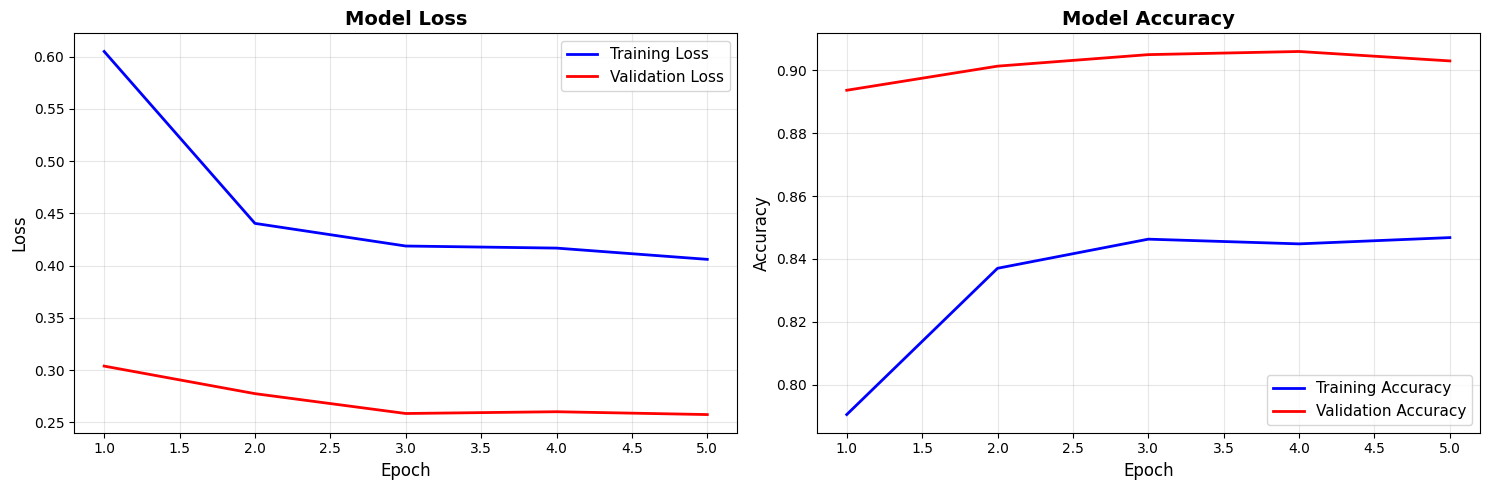

In [17]:
import matplotlib.pyplot as plt
import helper_utils


helper_utils.visualize_training_history(history_fe)
plt.show()

**Quick Check**: Visualize predictions

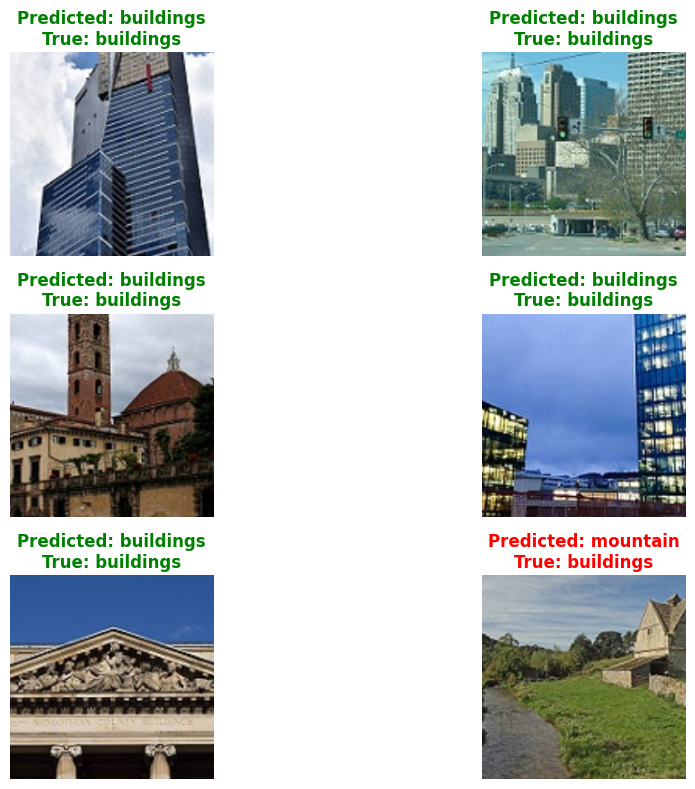

In [18]:
import matplotlib.pyplot as plt

class_names = train_dataset.classes

dataloaders = {"val": test_loader}

helper_utils.visualize_predictions(
    model_fe,
    dataloaders["val"],
    class_names,
    device,
    num_images=6
)
plt.show()


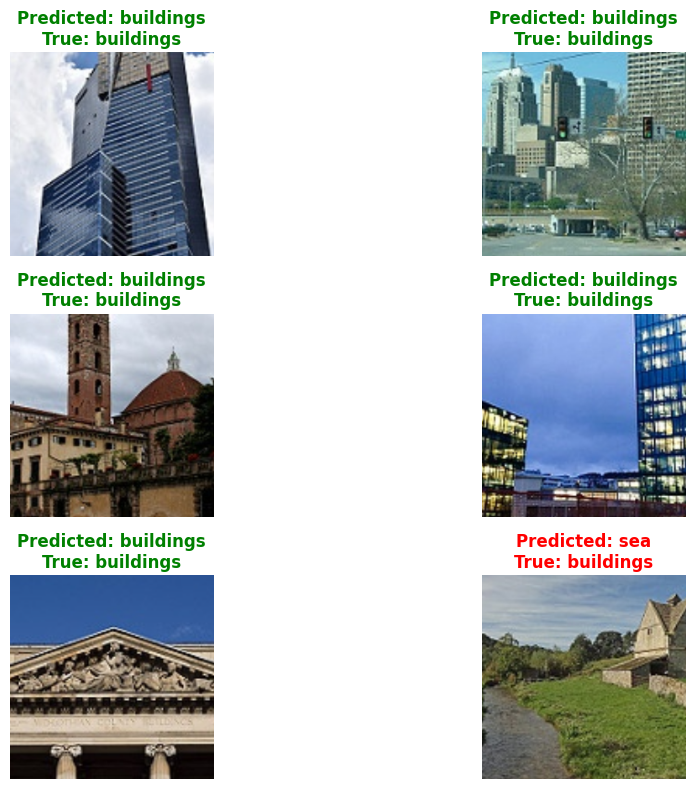

In [19]:
import matplotlib.pyplot as plt

class_names = train_dataset.classes

dataloaders = {"val": test_loader}

helper_utils.visualize_predictions(
    model_ft,
    dataloaders["val"],
    class_names,
    device,
    num_images=6
)
plt.show()


<a name='4-2'></a>
### 4.2 Fine-tuning the ConvNet

In this approach, we unfreeze all layers and train the entire network with a smaller learning rate.

**Task:**

1. Load a fresh pre-trained model
2. Modify the final layer
3. Set up optimizer for all parameters with a smaller learning rate
4. Train the model

In [20]:
# YOUR CODE HERE
import torch
import torch.nn as nn
from torchvision import models

NUM_CLASSES = 6

model_ft = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model_ft.fc = nn.Linear(model_ft.fc.in_features, NUM_CLASSES)
model_ft = model_ft.to(device)


In [21]:
# YOUR CODE HERE
for param in model_ft.parameters():
    param.requires_grad = True

In [22]:
# YOUR CODE HERE
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=1e-4)

In [23]:
# YOUR CODE HERE
history_ft = train_model(
    model_ft,
    train_loader,
    test_loader,
    criterion,
    optimizer_ft,
    device,
    epochs=5
)


Epoch 1/5 [train]:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 1/5 [val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 1/5 | train loss: 0.4239, train acc: 0.8460 | val loss: 0.2354, val acc: 0.9120


Epoch 2/5 [train]:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 2/5 [val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 2/5 | train loss: 0.3262, train acc: 0.8826 | val loss: 0.2133, val acc: 0.9213


Epoch 3/5 [train]:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 3/5 [val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 3/5 | train loss: 0.2942, train acc: 0.8901 | val loss: 0.1937, val acc: 0.9323


Epoch 4/5 [train]:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 4/5 [val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 4/5 | train loss: 0.2717, train acc: 0.9015 | val loss: 0.1991, val acc: 0.9293


Epoch 5/5 [train]:   0%|          | 0/439 [00:00<?, ?it/s]

Epoch 5/5 [val]:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch 5/5 | train loss: 0.2562, train acc: 0.9054 | val loss: 0.1884, val acc: 0.9317


**Quick Check**: Visualize training history

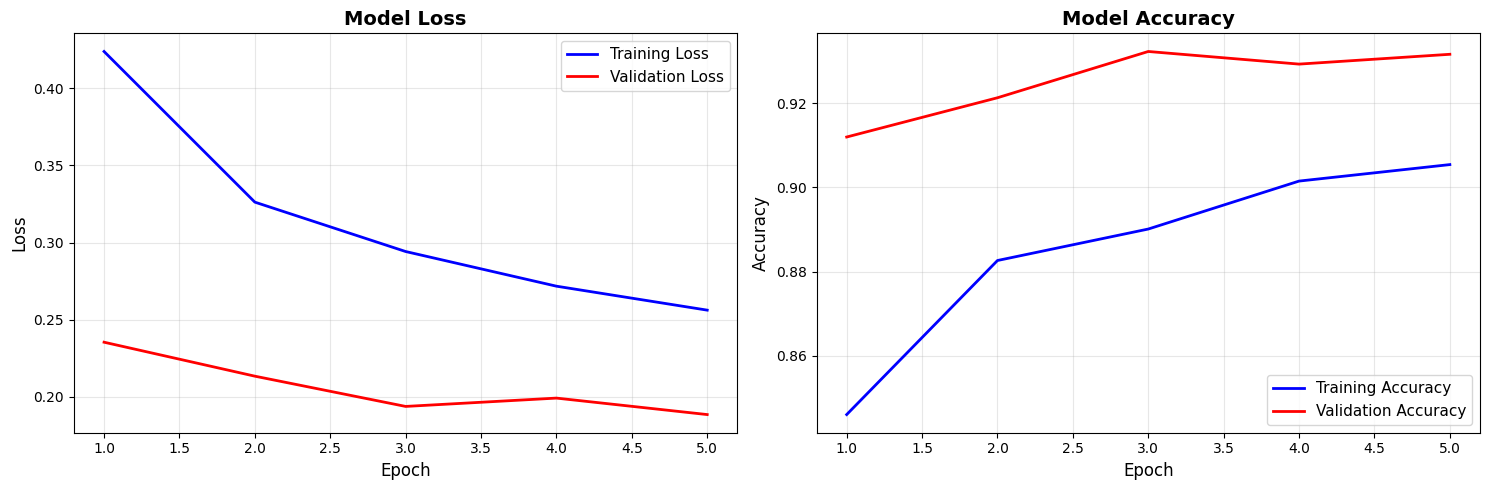

In [24]:
helper_utils.visualize_training_history(history_ft)
plt.show()

**Quick Check**: Visualize predictions

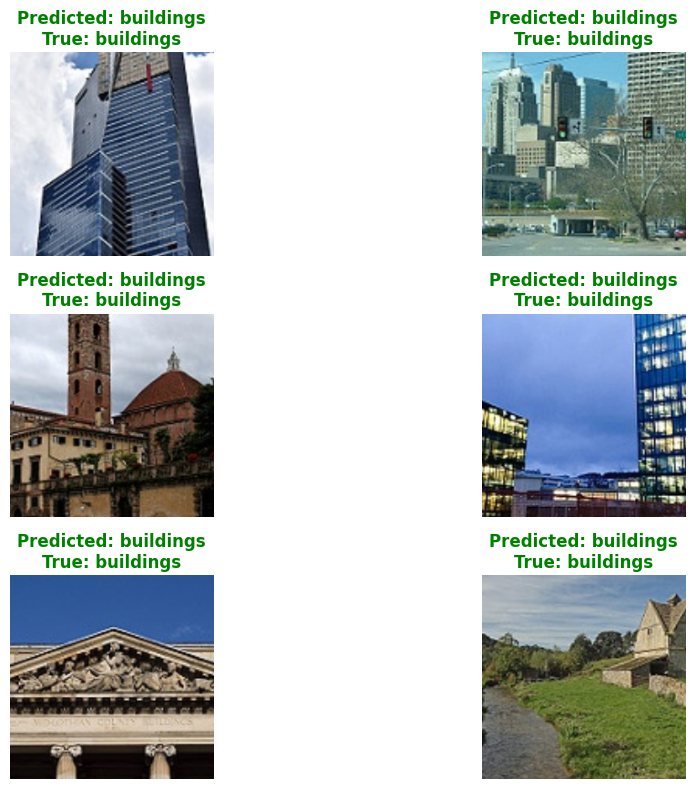

In [25]:
helper_utils.visualize_predictions(model_ft, dataloaders['val'], class_names, device, num_images=6)
plt.show()

<a name='5'></a>
## 5. Evaluation

Compare the performance of both approaches.

**Task:** Evaluate both models and compare their performance metrics.

In [26]:
# Evaluate models on validation set
# YOUR CODE HERE
# Compare final validation accuracies, training times, etc.

print("Feature Extractor Approach:")
print(f"  Best Val Accuracy: {max(history_fe['val_acc']):.4f}")
print(f"  Final Val Accuracy: {history_fe['val_acc'][-1]:.4f}")
print()

print("Fine-tuning Approach:")
print(f"  Best Val Accuracy: {max(history_ft['val_acc']):.4f}")
print(f"  Final Val Accuracy: {history_ft['val_acc'][-1]:.4f}")

Feature Extractor Approach:
  Best Val Accuracy: 0.9060
  Final Val Accuracy: 0.9030

Fine-tuning Approach:
  Best Val Accuracy: 0.9323
  Final Val Accuracy: 0.9317


<a name='6'></a>
## 6. Inference on Custom Images

Test your trained model on custom images.

**Task:** Load a custom image, preprocess it, and make a prediction using your trained model.

**Reference:** [Image Preprocessing](https://pytorch.org/vision/stable/transforms.html)

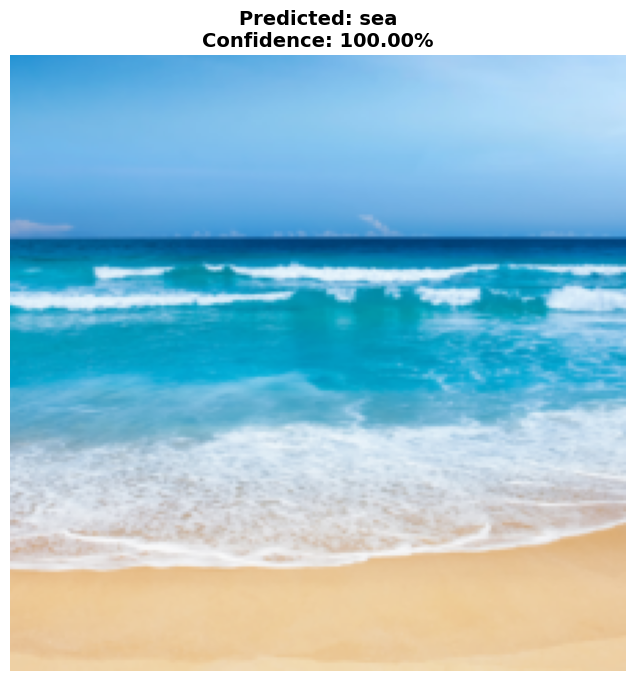

In [27]:
# Make prediction on a custom image
img_path = "Sea.jpg"

helper_utils.visualize_single_prediction(
    model_ft,
    img_path,
    val_transforms,
    class_names,
    device
)
plt.show()


# 🏆🎉 Congratulations on completing the Weekly Final Project! 🎉🏆

Fantastic job on finishing the Weekly Final Project! You’ve put your skills to the test and made it to the end. Take a moment to celebrate your hard work and dedication. Keep up the great work and continue your learning journey!

<a name='7'></a>
## 7. Deployment (ONNX)

Convert your trained model to ONNX format for deployment.

**Task:**
1. Convert the PyTorch model to ONNX format
2. Load the ONNX model and perform inference

**Reference:**
- [PyTorch to ONNX](https://docs.pytorch.org/tutorials/beginner/onnx/export_simple_model_to_onnx_tutorial.html)

In [29]:
!pip install onnx onnxscript

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 73.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.4/693.4 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.1/139.1 kB 15.3 MB/s eta 0:00:00


In [30]:
import torch

# Set model to evaluation mode
model_ft.eval()

# Dummy input (matches input shape of ResNet)
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export model to ONNX
onnx_path = "model_ft.onnx"
torch.onnx.export(
    model_ft,
    dummy_input,
    onnx_path,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={
        "input": {0: "batch_size"},
        "output": {0: "batch_size"}
    },
    opset_version=11
)

print(f"Model exported to {onnx_path}")


/tmp/ipython-input-2336666694.py:11: UserWarning: # 'dynamic_axes' is not recommended when dynamo=True, and may lead to 'torch._dynamo.exc.UserError: Constraints violated.' Supply the 'dynamic_shapes' argument instead if export is unsuccessful.
  torch.onnx.export(
W0108 17:54:14.652000 487 torch/onnx/_internal/exporter/_compat.py:114] Setting ONNX exporter to use operator set version 18 because the requested opset_version 11 is a lower version than we have implementations for. Automatic version conversion will be performed, which may not be successful at converting to the requested version. If version conversion is unsuccessful, the opset version of the exported model will be kept at 18. Please consider setting opset_version >=18 to leverage latest ONNX features


[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 127, in call
    converted_proto = _c_api_utils.call_onnx_api(
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/_c_api_utils.py", line 65, in call_onnx_api
    result = func(proto)
             ^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnxscript/version_converter/__init__.py", line 122, in _partial_convert_version
    return onnx.version_converter.convert_version(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/onnx/version_converter.py", line 39, in convert_version
    converted_model_str = C.convert_version(model_str, target_version)
                          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
RuntimeError: /github/workspace/onnx/version_converter/adapters/axes_input_to_attribute.h:65: adapt: Asserti

[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 40 of general pattern rewrite rules.
Model exported to model_ft.onnx


In [32]:
!pip install onnxruntime


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 126.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.8 MB/s eta 0:00:00


In [33]:
import onnxruntime as ort
import numpy as np
from PIL import Image

# Load ONNX model
ort_session = ort.InferenceSession("model_ft.onnx")

# Load and preprocess image (same transforms as validation)
img = Image.open(img_path).convert("RGB")
img = val_transforms(img)          # apply transforms
img = img.unsqueeze(0).numpy()     # shape: (1, 3, 224, 224)

# Run inference with ONNX
outputs = ort_session.run(
    None,
    {"input": img}
)

# Get predicted class
pred_class = outputs[0].argmax(axis=1)[0]
print("Predicted class:", class_names[pred_class])


Predicted class: sea
